# What is this document?
This notebook shall present the paper: _DiT: Self-Supervised Pre-Training for Document Image Transformers_

Throughout the notebook, the main ideas will be explained to lay a foundation for the main benchmarks, the base-model was fine-tuned and finally tested on. 

Since the pretaining process is the most interesting part of this paper, most of the effort goes into explaining the process. Due to its many components and the clever way of combining them, the pre-training shall be the main point of interest to pay attention to (and remember: _Attention is all you need_).

# Ressources and related Work

## **Blog's**
#### Image Transformers, general
https://dida.do/blog/visual-transformers

## **Papers**
#### [DiT] DiT: Self-supervised Pre-training for Document Image Transformer 
https://arxiv.org/pdf/2203.02378.pdf

#### [ATT_AYN] Attention is all you need 
https://arxiv.org/pdf/1706.03762.pdf

#### [ViT] An image is worth 16 x 16 words: Transformers for image recognition at scale (ViT)
https://arxiv.org/pdf/2010.11929.pdf

#### [VT] Visual Transformers: Token-based Image Representation and Processing for Computer Vision (VT)
https://arxiv.org/pdf/2006.03677.pdf

#### [BEIT] BEIT: BERT Pre-Training of Image Transformers (BEiT)
https://arxiv.org/pdf/2106.08254.pdf

#### [BERT] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
https://arxiv.org/pdf/1810.04805.pdf

#### [ZERO_TTI] Zero-shot text-to-image generation
https://arxiv.org/pdf/2102.12092.pdf

#### [M_RCNN] Mask R-CNN
https://arxiv.org/pdf/1703.06870.pdf

#### [C_RCNN] Cascade R-CNN: Delving into High Quality Object Detection
https://arxiv.org/pdf/1712.00726.pdf

#### [IIT_CDIP] Building a Test Collection for Complex Document Information Processing
https://ir.cs.georgetown.edu/downloads/sigir06cdipcoll_v05-with-authors.pdf

#### [RVL_CDIP] Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval
https://arxiv.org/pdf/1502.07058.pdf


## **Libraries** (aside from standards like pandas, sklearn, etc)
#### [HF] Hugging Face 
https://huggingface.co/docs

#### [DEC2] Detectron (2)
https://detectron2.readthedocs.io/en/latest/


##### Explaination of citation procedure
Due to the fact that now better option of citing within a Jupyter Notebook was found, then pasting the link aka. using an HTML-anker point (see: [VIT](http://localhost:8888/notebooks/_project/project/_notebooks/_total.ipynb#[ViT]-An-image-is-worth-16-x-16-words:-Transformers-for-image-recognition-at-scale-(ViT))), citing will be done without actually linking them, in the following fashion: 
- [DiT]
    - References: DiT: Self-supervised Pre-training for Document Image Transformer 
- [ATT_AYN]
    - References: Attention is all you need 
- so on 
    - and so forth 
    
Due to the fact that the anker pointing would open another Tab in the respective browser, this option is not viable. 
**How to fix it?**
A solution avoid this issue in the first place would be to realize such a document in the form of a Jupyter Book. Following assignments will be realized this way. 

# Imports, Functions, Globals
ALL MODELS: https://github.com/microsoft/unilm/tree/master/dit

In [1]:
# widen cells to be 95 % of width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# general
import pandas as pd 
import numpy as np 
import os
from pathlib import Path
import time 

# stats
from sklearn import preprocessing as sk_pre

# torch
import torch
from torchinfo import summary

### general architecture methods
# document classification
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, BeitForMaskedImageModeling, AutoModel 


# plotting
import matplotlib.pyplot as plt 
import seaborn as sn
sn.set_theme(palette="colorblind",)
sn.set_style(style='white')

# image processing 
from PIL import Image
import cv2

In [3]:
#########
# GLOBALS
#########
PATH_BASE = Path(os.path.abspath(''))
PATH_IMAGE_FOLDERS = PATH_BASE / '../dataset/rvl-cdip/images'
PATH_IMAGE_LABELS = PATH_BASE / '../dataset/rvl-cdip/labels'

M_CLASS_COUNT = 16
M_CLASS_LABELS = (
    'letter', 'form', 'email', 'handwritten', 
    'advertisement', 'scientific report', 
    'scientific' 'publication', 'specification', 
    'file folder', 'news article', 'budget', 
    'invoice', 'presentation', 'questionnaire', 
    'resume', 'memog'
)

HUB_PATH_BASE_MODEL = "microsoft/dit-base"
HUB_PATH_CLASSIFICATION_FT = HUB_PATH_BASE_MODEL + "-finetuned-rvlcdip"


#MODEL_BASE = 
FEATURE_EXTRACTOR_CLASSIFICATION_FT = AutoFeatureExtractor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
MODEL_CLASSIFICATION_FT = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")




#########
# METHODS
#########

def norm_to_range(arr: list = None, certain_max: int = None, certain_min: int = None) -> list:
    """Min-Max normalization with the option to pass certain mins an maxes"""
    if arr is None: 
        return ValueError("A list of None can not be normalized.")
    
    if certain_min is None: 
        mi = np.min(arr)
        
        # both none
        if certain_max is None: 
            return np.array((arr - mi) / (np.max(arr) - mi))
        
        # max not none
        return np.array((arr - mi) / (certain_max - mi))
    else:
        # bot not none
        if certain_max is None: 
            return np.array((arr - certain_min) / (certain_max - certain_min))
        
    return np.array((arr - certain_min) / (np.max(arr) - certain_min))
       
    
def inferre_model(im: Image = None, ex = FEATURE_EXTRACTOR_CLASSIFICATION_FT, mo = MODEL_CLASSIFICATION_FT) -> str: 
    """
    Inferres featres from the extractor and inferres the model
    return: str class label
    """
    if im is None: 
        return ValueError('The passed image is None')
    
    _in = ex(images=im, return_tensors="pt")
    _out = mo(**_in)
    logits = _out.logits
    
    y_hat = logits.argmax(-1).item()
    return mo.config.id2label[y_hat]


def draw_text_cv2(
    img, text,
    font=cv2.FONT_HERSHEY_PLAIN, pos=(0, 0),
    font_scale=3, font_thickness=2, 
    text_color=(0, 255, 0), text_color_bg=(0, 0, 0)
    ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

# Pre-Training

## Dataset

IIT-CDIP - https://dl.acm.org/doi/10.1145/1148170.1148307 - [Free Access] https://ir.cs.georgetown.edu/downloads/sigir06cdipcoll_v05-with-authors.pdf

The IIT-CDIP is a dataset containing roughly 42 million images from the tobaccoo industry and sums up to around 1.5 terabytes of image data. Following are unscaled examples of the images used for pre-training. 

> **_NOTE:_**  The images are all gray-scale images. Though, the model shall be capable to work with color images. Therefore, the R-, G- and B-channels have been filled with the pixel-values of the one available channel.



| ![ALT](./presentation_images/sample_image_pre.png "Sample Images of Pre-Training Process") | 
|:--:| 
| *Source: [DIT]* |

## Pre-Training and Architecture

| ![ALT](./presentation_images/base_pre_training.png "DIT Pre-Training Setup") | 
|:--:| 
| *Source: [DIT]* |


### Pre-Training DiT
During Pre-Training, the objective of the DiT Encoder was to predict the indices. To train the DiT Encoder more effectively, _Masked Image Modelling_ (MIM) is used here. 

**Masked Image Modeling:**
In Machine Learning in general, masked signal learning is a type of learning where some parts of the input are obscured or replaced entirely. For such cases, the model typically tries to recreate the obscured parts from the uncorrupted input. This technique comes from the field of _Natural Language Processing_ where it can be categorized in two groups: 
- _uni-directional_: 
    - The input to such a model is just a starting token and an arbitrary word or sequence to begin with eventually. The model then predicts the next word in the given sequence and the now extended sequence will be the input for the next word to be predicted. 
    - Implications: The context of the model will only ever be the parts of the sequence that are generated to far.
    - Usage: Generally, such models are better for generative tasks. E.g. setting the start of a sentence and letting the model finish it. 
- _bi-directional_: 
    - The input to the model are vectors of a fixed length $ N $. Different than the _uni-directional_ approach, the model has acccess to the entire input sequence at all times. 
    - Implications: The model has the context from both, the left and the right side.
    - Usage: Generally, such models are better at learning a good embedding for say classification or translation of sentences. 

MiM, as it is used in [DIT]. The procedure in use is an exact copy of the procedure as it is used in [BEIT], which is based on the bi-directional set-up.

#### Components denoted in the image above
**1:**
The original input data from  for pre-training, without any rescaling operations of the image.

#### A
**A1:**
After resizing an input image to the desired shape ( $ 224 x 224 x 3 $ ), the image will be split into 16 regions ( $ 16 x 16 x 3 $ ), that will be serialized into an array. The array of patches will then be prepended by a special token $ [CLS] $ and a learnable 1D positional embedding will be added to the array. Further, randomly chosen parts of the respective batches will be masked, where the positions are chosen at random. Roughly ~40% of the respective patches will be replaced by the $ [M] $ item. The result of this step will be a sequence of the $ [CLS] + 16 $ patches, with some parts of the patches being masked. 

**A2:**
As mentioned above, [DIT] follows the procedure for pre-training and uses the exact same architecture as BEiT. That said, the following paragraph will explain the backbone network - namely: the DiT Encoder.
Following the architecture for the backbone model in [VIT], the standard _Transformer Blocks_ from [ATT_AYN] are used to construct the backbone. This is not only due to the capabilities of the _Transformer Blocks_ presented in [ATT_AYN], but also to be able to properly compare the results to those presented in their paper [DIT] in a fair sense. 

The input to the backbone is the output of **A1**, which is a sequence of length $ 17 $ - which is denoted as: 
$ \{ x_i^p \}_{i=1}^N $. 
Then, the patches are linearly projected (inspired by: [BERT]) to obtain the patch embeddings 
$ \mathbf{E}\mathbf{x}_i^p $, where $ \mathbf{E} \in \mathbb{R}^{(P^2 C) \times D} $. 
$ P $ is the resolution of the resulting patch ($ 16 $), $ C $ is the number of channels ($ 3 $) and $ D $ being the projection. So, the input to the first Tansformer Block [ATT_AYN] will be a vectors of kind $ H_{IN} = [ e_{[CLS]}, \mathbf{E}\mathbf{x}_i^p, \cdot\cdot\cdot, \mathbf{E}\mathbf{x}_N^p ] + \mathbf{E}_{pos} $. The output of the last layer $ \mathbf{H}^L = [ \mathbf{h}_{[CLS]}^L, \mathbf{h}_{1}^L, \cdot\cdot\cdot, \mathbf{h}_N^L ] $ 
is then interpreted as the representations of the image patches, with $ \mathbf{h}_i^L $ being the $ i $ -th vector of the $ i $-th image patch.

This part of the model exists in two versions, where the paper differentiates between a _BASE_ and a _LARGE_ version: 

_BASE_:
- Layered Transformers: 12
- Hidden Size: 768
- Attention Heads: 12
- Attention Head Size: 64
- (MIM Head) Feed Forward Network Parameters: 3072

_LARGE_:
- Layered Transformers: 24
- Hidden Size: 1024
- Attention Heads: 16
- Attention Head Size: 64
- (MIM Head) Feed Forward Network Parameters: 4096

**A3:**
The Masked Image Modelling Head (MiM Head) is a simple Feed Forward Network, trained to predict the indices present in the index-table (**B2**) from the discrete Variational Auto-Encoder (dVAE). 

**A4:**
To only get the indices that got masked in **A1**, a Boolean mask-array will be passed and multiplied with the output vector of the MIM Head. This then results in only those indices we are interested in during pre-training. 


#### B
**B1:**
Similarly to language models, images can be represented as a sequence of discrete tokens. These tokens are obtained by the _Tokenizer_. Following [ZERO_TTI], the image is tokenized by a dVAE. Differing from [BEIT], the researchers did not use the pre-trained _Tokenizer_. Instead, they trained it themselves, together with the [DiT] _Encoder_, to allow for an end-to-end training process of both of these components. Further, they proposed that the domain-mismatch between the natural image on which the Tokenizer of DALL-E [ZERO_TTI] was trained, is too prominent. Their own _Tokenizer_ is trained on the IIT-CDIP dataset from [this](https://ir.cs.georgetown.edu/downloads/sigir06cdipcoll_v05-with-authors.pdf)

The _Tokenizers_ job is to learn to map image's pixels $ \mathbf{x} $ into discrete tokens $ \mathbf{z} $, according to a visual codebook - the vocabulary of size $ 8192 $. 

**B2:**
The _Decoder_ is supposed to learn to reconstruct the input image's pixels $ \mathbf{x} $ based on the tokens $ \mathbf{z} $ present in **B3**. In the case of [DiT], $ \mathbf{z}  = [ z_1, \cdot\cdot\cdot, z_N ] \in V^{h \times w}$, with $ w $ as the width and $ h $ as the height of the patches.

**B3:**
The Visual Codebook ("Embedding Table" in the image above). The codebook carries 8192 ($ | V | = 8192 $) distinct vectors of length.

**B4:**
The index table containing the indices to the embeddings in **B3** of the current timestep $ t $.

> **_Note_**: 
The loss $ \mathbf{L}_{MSE} $ will not be differentiatable, due to the quantization step realized by the dVAE. To solve that issue, the researchers from [ZERO_TTI] applied a simple, yet clever solution. Together with the use of _Gumbel-softmax relaxation_, the weight-correction of Decoders input neurons of **B2** will be copied to the output neurons of the Tokenizer of **B1**. By doing so, the researchers "cheated" their way to a continuous function for back propagation. (_For the curious ones_: More about the training of the dVAE in regards to the _Gumbel-softmax relaxation_ can be found [here](https://openreview.net/forum?id=S1jE5L5gl))


### Comparison to BEiT


| ![ALT](./presentation_images/beit_architecture_pre_training.png "BEiT Pre-Training Setup") | 
|:--:| 
| *Source: [BEIT]* |

Directly comparing the two pre-training procedures, one will eventually notice that there is no obvious difference between the two. As a matter of fact, there is none. 

Now that it is clear, that the procedures are in fact the same, there still is the question of **how do the setups differ?**
In the regard to the pre-training, the two papers mainly differ in the dataset used to do the pre-training. Other than that, [BEIT] used the pre-trainied _Tokenizer_ from DALL-E [ZERO_TTI]. As mentioned before, the researchers from [DIT] decided against using the DALL-E's _Tokenizer_, due to the domain-mismatch of natural and document images.
- [DIT] pre-training dataset: https://ir.cs.georgetown.edu/downloads/sigir06cdipcoll_v05-with-authors.pdf
    - ~42 million images
- [BEIT] pre-training dataset: https://image-net.org/
    - 14 million images

# Practical Implementation

## Document Image Classification

### How to adjust the _Encoder_ for Classification tasks and the respective fine-tuning?
For the process of fine-tuning, the researchers take the pre-trained _Encoder_ and supended it with a simple linear classifier. To make use of output from the _Encoder_, average pooling is used to aggregate the representations of the image patches. 

There exists an implementation from Hugginface [HF], which was used in this notebook. 

#### Dataset for fine-tuning
The dataset used is the [RVL_CDIP], which is one of the main benchmark datasets used for evaluating a Document Classification Model.

The dataset contains 16 distinct classes:
- 0 letter
- 1 form
- 2 email
- 3 handwritten
- 4 advertisement
- 5 scientific report
- 6 scientific publication
- 7 specification
- 8 file folder
- 9 news article
- 10 budget
- 11 invoice
- 12 presentation
- 13 questionnaire
- 14 resume
- 15 memo


As it is typical for at least academical datasets, it split into 3 strict subsets: 

- _train_: 
    - 320 k samples
- _test_: 
    - 40 k samples
- _validation_:
    - 40 k samples

### Distribution of classes in subsets (train, test, validation) of the [RVL_CDIP] dataset

In [4]:
value_counts = pd.DataFrame(columns=['set', 'cnt', 'norm_cnt', 'class'])

try: 
    for s, _s in [('train', 20000), ('test', 2500), ('val', 2500)]: 
        
        # open the file and read by lines
        with open(f'./../dataset/rvl-cdip/labels/{s}.txt', 'r') as f: 
            string_list = f.readlines()
            
        labels = []
        for l in string_list:
            labels.append(int(l.split(' ')[1].strip('\n')))
        
        vc = np.unique(labels, return_counts=True) 
        # generate and concatenate row for df 
        value_counts = pd.concat(
            [
                value_counts, 
                pd.DataFrame({'set': [s]*len(vc[0]), 'cnt': vc[1], 'norm_cnt':[x / _s for x in vc[1]], 'class': vc[0]})
            ], ignore_index=True)
    

    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax = sn.barplot(ax=ax, data=value_counts, x='class', y='norm_cnt', hue='set')
    ax.set(
        title='Relativ distribution of classes in data sets\n(Train: 25k, Test: 2.5k, Validation: 2.5k)', 
        xlabel='Classes',
        ylim=1.05,
        ylabel='Occurence relativ to set value', 
        yticks=np.arange(0, 1.1, 0.1),
        
    )
    ax.grid(False)
    ax.hlines(y=1, xmax=15.5, xmin=-.5, colors='red')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.savefig('./presentation_images/rvl_dist.png')
    plt.close()

except: 
    print("Probebly, the dataset is not installed. You still need to download it?")


Probebly, the dataset is not installed. You still need to download it?


![ALT](./presentation_images/rvl_dist.png "RVL class distribution over training sets")

### Example image of train

(1000, 754, 3)

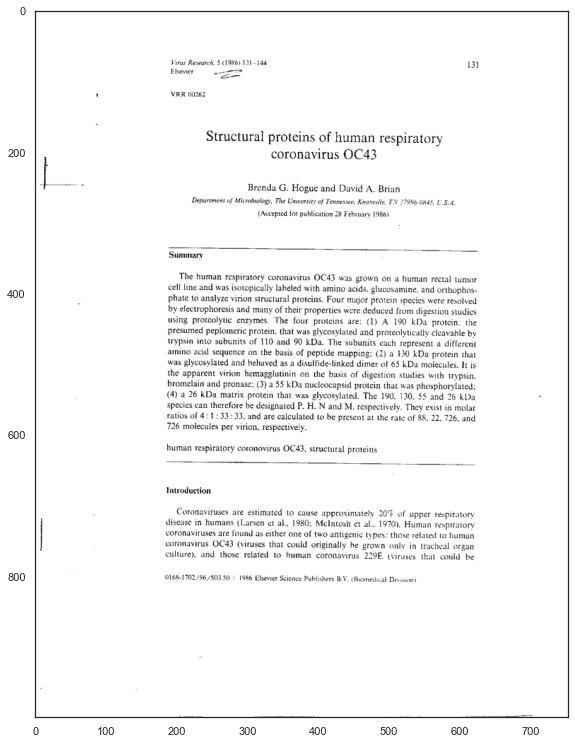

In [5]:
fig, ax = plt.subplots(figsize=(10, 13))

try: 
    sample_image = Image.open(PATH_IMAGE_FOLDERS / 'imagesa/a/a/a/aaa06d00/50486482-6482.tif').convert('RGB')
except: 
    sample_image = Image.open('./presentation_images/50486482-6482.tif').convert('RGB')

sample = np.array(sample_image)
ax.imshow(sample)
sample.shape

| | 
|:--:| 
| *Source: [DIT]* |

### Example image of model inputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


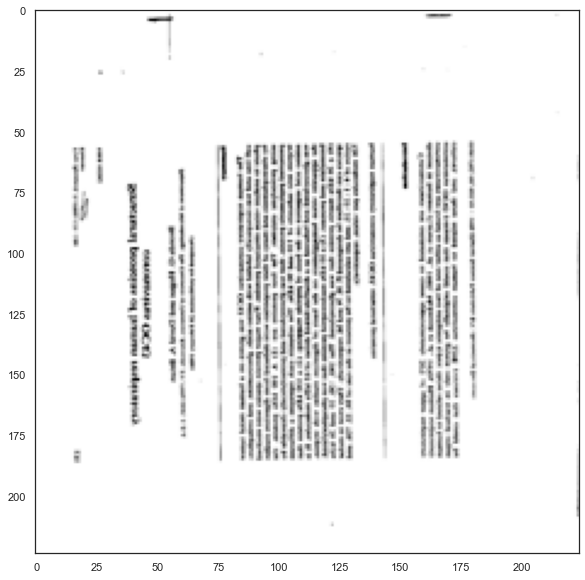

In [6]:
# inference test with train image 
inputs = FEATURE_EXTRACTOR_CLASSIFICATION_FT(images=sample_image, return_tensors="pt")
outputs = MODEL_CLASSIFICATION_FT(**inputs)
logits = outputs.logits

fig, ax = plt.subplots(figsize=(10, 10))

plt.imshow(np.swapaxes(np.array(inputs['pixel_values'])[0], 0, 2))

| | 
|:--:| 
| *Source: [DIT]* |

### Model test


In [7]:

# model predicts one of the 16 RVL-CDIP classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", MODEL_CLASSIFICATION_FT.config.id2label[predicted_class_idx])

Predicted class: scientific publication


### Webcam live demo


In [8]:
# capturing = cv2.VideoCapture(0)
# capturing.set(3, 640)
# capturing.set(4, 400)
# 
# while True:
#     _, img = capturing.read()
#     
#     # get label from model
#     y_hat = inferre_model(img)
#     
#     # add classification to image output 
#     draw_text_cv2(img, text=y_hat)
#     
#     cv2.imshow("Webcam", img) # This will open an independent window
#     if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
#         capturing.release()
#         break
#         
#     # slow down the camera and inference
#     for i in range(100000): 
#         continue
#         
# cv2.destroyAllWindows() 
# cv2.waitKey(1) 

## Layout Analysis and Detection

### How to adjust the _Encoder_ for Layout Analysis and Detection tasks and the respective fine-tuning?
For the process of fine-tuning, the researchers take the pre-trained _Encoder_ and supended it with Mask R-CNN [M_RCNN] or Cascade R-CNN [C_RCNN] as a detection framework. The implementation takes place in the realm of Dectron [DEC2], which is why the usage is a bit more complex, compared to the code necessary for the implementation from Huggingface [HF].

> **Note:**
Since the Task of Layout Analysis and Table Detection are the same, from the perspective of the networks task, thus similar detection frameworks are used ([M_RCNN], [C_RCNN]).



#### Dataset for fine-tuning
The Detection- and Layout Analysis tasks are split into 3 fine-tunings on 3 different datasets respectively. Following, the datasets will be briefly expained, together with the corresponding tasks. 

**Fine-tuning on ICSAR 2019 cTDaR - Table Detection & Table Recognition:**<br />
Access to the dataset: https://cndplab-founder.github.io/cTDaR2019/<br />
Network extension: Cascade R-CNN [C_RCNN]<br />

The dataset consists of handwritten archival document, scientific journals, repots, financial statements and more distict types of documents containing tables. This dataset evaluates two aspects of the task at hand: table recognition (answers the question: Is there a table anywhere?) and table detection (answers the question: Where are there tables?) Moreover, the datasets is generally split into two subgroups. The first contains handwritten documents from the early 20th century, some of which dated in 1903. The second contains modern documents from the late 20th century and the 21st century. 


**Fine-tuning on PubLayNet:**<br />
Access to the paper behind the creation of the dataset: https://arxiv.org/pdf/1908.07836.pdf<br />
Access to the dataset: https://github.com/ibm-aur-nlp/PubLayNet<br />
Network extension: Cascade R-CNN [C_RCNN]<br />

The dataset soley consists of scientific reports, essays and papers from the medical context. As the dataset before, it is one of the main benchmark datasets for its specific task. The task this dataset was used for is the Document Layout Analysis task.


**Fine-tuning on FUNSD:**<br />
Access to the paper behind the creation of the dataset: https://arxiv.org/pdf/1905.13538.pdf<br />
Access to the dataset: https://guillaumejaume.github.io/FUNSD/download/<br />
Network extension: Mask R-CNN [M_RCNN]<br />

This dataset is a subset of the [RVL_CDIP] datasets form category. For the purpose of Layout Analysis, Optical Character Recognition and entity linking, the datasets contains 199 forms, that have been annoted and extended with further informations (e.g. the linking aspect which depicts e.g. which headline corresponds to which text). 

### Neccessary classes

In [9]:
# --------------------------------------------------------------------------------
# VIT: Multi-Path Vision Transformer for Dense Prediction
# Copyright (c) 2022 Electronics and Telecommunications Research Institute (ETRI).
# All Rights Reserved.
# Written by Youngwan Lee
# This source code is licensed(Dual License(GPL3.0 & Commercial)) under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# CoaT: https://github.com/mlpc-ucsd/CoaT
# --------------------------------------------------------------------------------

import sys
sys.path.append('./../unilm/dit/object_detection/ditod/')


import torch

# Facebook imports
from detectron2.layers import (
    ShapeSpec,
)
from detectron2.modeling import Backbone, BACKBONE_REGISTRY, FPN
from detectron2.modeling.backbone.fpn import LastLevelP6P7, LastLevelMaxPool

# microsoft imports 
from beit import beit_base_patch16, dit_base_patch16, dit_large_patch16, beit_large_patch16
from deit import deit_base_patch16, mae_base_patch16

__all__ = [
    "build_vit_fpn_backbone",
]


class VIT_Backbone(Backbone):
    """
    Implement VIT backbone.
    """

    def __init__(self, name, out_features, drop_path, img_size, pos_type, model_kwargs):
        super().__init__()
        self._out_features = out_features
        if 'base' in name:
            self._out_feature_strides = {"layer3": 4, "layer5": 8, "layer7": 16, "layer11": 32}
        else:
            self._out_feature_strides = {"layer7": 4, "layer11": 8, "layer15": 16, "layer23": 32}

        if name == 'beit_base_patch16':
            model_func = beit_base_patch16
            self._out_feature_channels = {"layer3": 768, "layer5": 768, "layer7": 768, "layer11": 768}
        elif name == 'dit_base_patch16':
            model_func = dit_base_patch16
            self._out_feature_channels = {"layer3": 768, "layer5": 768, "layer7": 768, "layer11": 768}
        elif name == "deit_base_patch16":
            model_func = deit_base_patch16
            self._out_feature_channels = {"layer3": 768, "layer5": 768, "layer7": 768, "layer11": 768}
        elif name == "mae_base_patch16":
            model_func = mae_base_patch16
            self._out_feature_channels = {"layer3": 768, "layer5": 768, "layer7": 768, "layer11": 768}
        elif name == "dit_large_patch16":
            model_func = dit_large_patch16
            self._out_feature_channels = {"layer7": 1024, "layer11": 1024, "layer15": 1024, "layer23": 1024}
        elif name == "beit_large_patch16":
            model_func = beit_large_patch16
            self._out_feature_channels = {"layer7": 1024, "layer11": 1024, "layer15": 1024, "layer23": 1024}
        else:
            raise ValueError("Unsupported VIT name yet.")

        if 'beit' in name or 'dit' in name:
            if pos_type == "abs":
                self.backbone = model_func(img_size=img_size,
                                           out_features=out_features,
                                           drop_path_rate=drop_path,
                                           use_abs_pos_emb=True,
                                           **model_kwargs)
            elif pos_type == "shared_rel":
                self.backbone = model_func(img_size=img_size,
                                           out_features=out_features,
                                           drop_path_rate=drop_path,
                                           use_shared_rel_pos_bias=True,
                                           **model_kwargs)
            elif pos_type == "rel":
                self.backbone = model_func(img_size=img_size,
                                           out_features=out_features,
                                           drop_path_rate=drop_path,
                                           use_rel_pos_bias=True,
                                           **model_kwargs)
            else:
                raise ValueError()
        else:
            self.backbone = model_func(img_size=img_size,
                                       out_features=out_features,
                                       drop_path_rate=drop_path,
                                       **model_kwargs)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.
        Returns:
            dict[str->Tensor]: names and the corresponding features
        """
        assert x.dim() == 4, f"VIT takes an input of shape (N, C, H, W). Got {x.shape} instead!"
        return self.backbone.forward_features(x)

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }


def build_VIT_backbone(cfg):
    """
    Create a VIT instance from config.
    Args:
        cfg: a detectron2 CfgNode
    Returns:
        A VIT backbone instance.
    """
    # fmt: off
    name = cfg.MODEL.VIT.NAME
    out_features = cfg.MODEL.VIT.OUT_FEATURES
    drop_path = cfg.MODEL.VIT.DROP_PATH
    img_size = cfg.MODEL.VIT.IMG_SIZE
    pos_type = cfg.MODEL.VIT.POS_TYPE

    model_kwargs = eval(str(cfg.MODEL.VIT.MODEL_KWARGS).replace("`", ""))

    return VIT_Backbone(name, out_features, drop_path, img_size, pos_type, model_kwargs)


@BACKBONE_REGISTRY.register()
def build_vit_fpn_backbone(cfg, input_shape: ShapeSpec):
    """
    Create a VIT w/ FPN backbone.
    Args:
        cfg: a detectron2 CfgNode
    Returns:
        backbone (Backbone): backbone module, must be a subclass of :class:`Backbone`.
    """
    bottom_up = build_VIT_backbone(cfg)
    in_features = cfg.MODEL.FPN.IN_FEATURES
    out_channels = cfg.MODEL.FPN.OUT_CHANNELS
    backbone = FPN(
        bottom_up=bottom_up,
        in_features=in_features,
        out_channels=out_channels,
        norm=cfg.MODEL.FPN.NORM,
        top_block=LastLevelMaxPool(),
        fuse_type=cfg.MODEL.FPN.FUSE_TYPE,
    )
    return backbone

### Imports and Functions

In [10]:
#from ditod import add_vit_config
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor

from detectron2.config import CfgNode as CN


def add_vit_config(cfg):
    """
    Add config for VIT.
    """
    _C = cfg
    _C.MODEL.VIT = CN()
    # CoaT model name.
    _C.MODEL.VIT.NAME = ""
    # Output features from CoaT backbone.
    _C.MODEL.VIT.OUT_FEATURES = ["layer3", "layer5", "layer7", "layer11"]
    _C.MODEL.VIT.IMG_SIZE = [224, 224]
    _C.MODEL.VIT.POS_TYPE = "shared_rel"
    _C.MODEL.VIT.DROP_PATH = 0.
    _C.MODEL.VIT.MODEL_KWARGS = "{}"
    _C.SOLVER.OPTIMIZER = "ADAMW"
    _C.SOLVER.BACKBONE_MULTIPLIER = 1.0
    _C.AUG = CN()
    _C.AUG.DETR = False

In [11]:
## Hacky way to access the exact architecture in use within Dectron 2
# from detectron2.engine import DefaultTrainer
# 
# 
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

### Inference

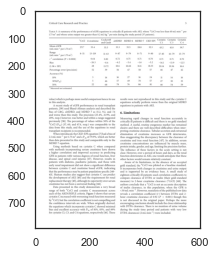

/Users/Nick/Documents/HDM/MASTER/1_SEM/objRecognition/_project/uni_object_recognition_project/venv/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/Users/Nick/Documents/HDM/MASTER/1_SEM/objRecognition/_project/uni_object_recognition_project/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/Users/Nick/Documents/HDM/MASTER/1_SEM/objRecognition/_project/uni_object_recognition_project/venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use t

In [12]:
# instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("./../unilm/dit/object_detection/publaynet_configs/maskrcnn/maskrcnn_dit_base.yaml")

# add model weights URL to config
cfg.merge_from_list(["MODEL.WEIGHTS", "https://layoutlm.blob.core.windows.net/dit/dit-fts/publaynet_dit-b_mrcnn.pth"])

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device

# define model
predictor = DefaultPredictor(cfg)


# run inference
img = cv2.imread("./presentation_images/publaynet_example.jpeg")
plt.imshow(img)
plt.show()

md = MetadataCatalog.get(cfg.DATASETS.TEST[0])
md.set(thing_classes=["text","title","list","table","figure"])

output = predictor(img)["instances"]
v = Visualizer(img[:, :, ::-1],
                md,
                scale=1.0,
                instance_mode=ColorMode.SEGMENTATION)
result = v.draw_instance_predictions(output.to("cpu"))
result_image = result.get_image()[:, :, ::-1]
 
# save detection
cv2.imwrite("./presentation_images/publaynet_example_inferred.jpeg", result_image)
plt.close()

#### Document Image Classification
![ALT](./presentation_images/publaynet_example_inferred.jpeg "Classification") 

# Benchmark Results

## Document Image Classification
| ![ALT](./presentation_images/results_classification.png "Classification") | 
|:--:| 
| *Source: [DIT]* |

## Document Layout Analysis on PubLayNet
| ![ALT](./presentation_images/results_layout_publeynet.png "Layout Analysis") | 
|:--:|
| *Source: [DIT]* |

## Table Detection on ICDAR 2019 cTDaR
| ![ALT](./presentation_images/results_table_detection.png "Table Detection") | 
|:--:| 
| *Source: [DIT]* |

##  Text Detection on FUNSD
| ![ALT](./presentation_images/results_text_detection.png "Text Detection") | 
|:--:| 
| *Source: [DIT]* |


# Conclusion

The results presented in the paper: **DiT: Self-supervised Pre-training for Document Image Transformer** show, that the [DIT] _Encoder_ is capable to achieve state-of-the-art (SOTA) results for the document related tasks at hand. Setting new SOTA standards for multiple benchmarks with one model is an achievement worth pursuing. 

A small grain of salt? <br/>
In all of the cases when new sota standards are set, it is the large version of the _Encoder_ setting those. Even when training the base version would already be cost-intensive. Though, in absolut number, the base model is better in some situations.

The paper is not a theoretical work, meaning it does not invent a new technique or architecture. All the processes, techniques and architectures used for the models and the corresponding pre-processing steps are created by other researchers. Nevertheless, showing and proving that present ideas can be used in a large scale, and thus can up the SOTA standards, is an important question to answer. <br/>
Other than that, all the models and checkpoints of the different settings (DIT Base, DIT Large in permutation with the fine-tunings) are freely available for non-commercial usage, which is not always the case. 

_From a learning student point of view:_
This paper can be a good read for those familiar with the underlying ideas or rather those who read the papers [DIT] is based upon. Though, this paper has a lot of very interesting pointers. The papers mentioned in the references [ATT_AYN], [BEIT], [BERT], to name a few are theretical works and introduced important and interesting ideas to the field. Additionally, starting with those will allow one to fully grasp, what is the good points of this paper really are. 
